<a href="https://colab.research.google.com/github/basu-a/ML_UChicago/blob/master/Machine_Learning_Project_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

# Load the TensorBoard notebook extension.
%load_ext tensorboard

TensorFlow 2.x selected.


In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from datetime import datetime
from packaging import version

import tensorflow as tf
from tensorflow import keras

print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >= 2, \
    "This notebook requires TensorFlow 2.0 or above."

TensorFlow version:  2.0.0


In [0]:
import librosa
import librosa.feature
import librosa.display
import glob
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.utils.np_utils import to_categorical
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

Using TensorFlow backend.


In [0]:
def display_mfcc(song):
    y, _ = librosa.load(song)
    mfcc = librosa.feature.mfcc(y)

    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mfcc, x_axis='time', y_axis='mel')
    plt.colorbar()
    plt.title(song)
    plt.tight_layout()
    plt.show()


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
datasets = "/content/gdrive/My Drive/datasets/Music/"

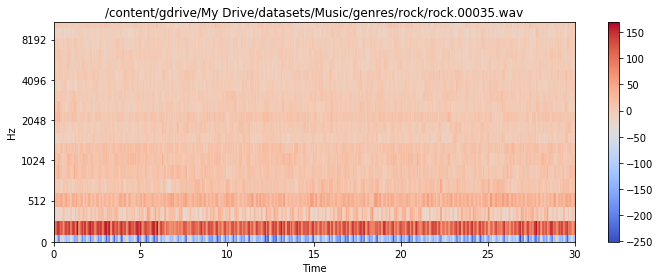

In [0]:
display_mfcc(datasets+'genres/rock/rock.00035.wav')

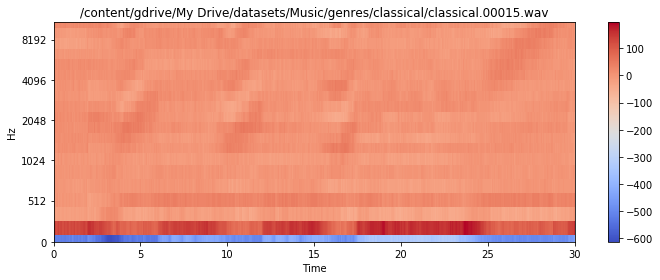

In [0]:
display_mfcc(datasets+'genres/classical/classical.00015.wav')

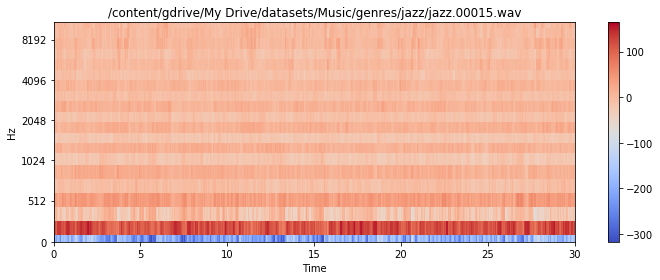

In [0]:
display_mfcc(datasets+'genres/jazz/jazz.00015.wav')

In [0]:
def extract_features_song(f):
    y, _ = librosa.load(f)

    # get Mel-frequency cepstral coefficients
    mfcc = librosa.feature.mfcc(y)
    # normalize values between -1,1 (divide by max)
    mfcc /= np.amax(np.absolute(mfcc))

    return np.ndarray.flatten(mfcc)[:25000]

In [0]:
def extract_features_song_2(f):
    y, _ = librosa.load(f)

    # get Mel-frequency cepstral coefficients
    mfcc = librosa.feature.mfcc(y)
    # normalize values between -1,1 (divide by max)
    mfcc /= np.amax(np.absolute(mfcc))

    return mfcc

In [0]:
y =librosa.load(datasets+'genres/rock/rock.00029.wav')


In [0]:
extract_features_song_2(datasets+'genres/rock/rock.00030.wav').shape


(20, 1293)

In [0]:
def generate_features_and_labels():
    all_features = []
    all_labels = []

    genres = ['blues','classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
    for genre in genres:
        sound_files = glob.glob(datasets+'genres/'+genre+'/*.wav')
        print('Processing %d songs in %s genre...' % (len(sound_files), genre))
        for f in sound_files:
            features = extract_features_song_2(f)
            all_features.append(features[:,:1290])
            all_labels.append(genre)

    # convert labels to one-hot encoding
    label_uniq_ids, label_row_ids = np.unique(all_labels, return_inverse=True)
    label_row_ids = label_row_ids.astype(np.int32, copy=False)
    onehot_labels = to_categorical(label_row_ids, len(label_uniq_ids))
    return np.stack(all_features), onehot_labels

In [0]:
k = generate_features_and_labels()

Processing 100 songs in blues genre...
Processing 100 songs in classical genre...
Processing 100 songs in country genre...
Processing 100 songs in disco genre...
Processing 100 songs in hiphop genre...
Processing 100 songs in jazz genre...
Processing 100 songs in metal genre...
Processing 100 songs in pop genre...
Processing 100 songs in reggae genre...
Processing 100 songs in rock genre...


In [0]:
features = k[0]
labels = k[1]

In [0]:
import csv

with open(datasets+'saved/'+'features.txt', 'w') as f:
    csvwriter = csv.writer(f)
    csvwriter.writerows(features)

In [0]:
import csv

with open(datasets+'saved/'+'labels_2.txt', 'w') as f:
    csvwriter = csv.writer(f)
    csvwriter.writerows(labels)

In [0]:
reshaped_features = []
for items in features:
  reshaped_features.append(items[:,:1290])

In [0]:
reshaped_features_stacked = np.stack(reshaped_features)

In [0]:
features[0].shape

(20, 1293)

In [0]:
import random

test = random.sample(range(1, 1000), 200)
len(test)

200

In [0]:
from sklearn.model_selection import train_test_split

train_input, test_input, train_labels, test_labels = train_test_split(reshaped_features_stacked, labels, test_size=0.3)

In [0]:
train_input[1].shape


()

In [0]:
from tensorflow.keras.models import Sequential


model = Sequential()

model.add(tf.keras.layers.Conv1D(1024, 3, padding='same',input_shape=(train_input[1].shape))) 
model.add(tf.keras.layers.Activation('relu'))

model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.MaxPooling1D(pool_size=(2)))

model.add(tf.keras.layers.Conv1D(256, 5, padding='same'))
model.add(tf.keras.layers.Activation('relu')) 
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Conv1D(1024, 3, padding='same'))
model.add(tf.keras.layers.Activation('relu')) 
model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.MaxPooling1D(pool_size=(4)))


model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(1024, activation= 'relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(512, activation= 'relu'))
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(256, activation= 'relu'))
model.add(tf.keras.layers.Dense(10)) 
model.add(tf.keras.layers.Activation('softmax'))


model.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
print(model.summary())


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 20, 1024)          3963904   
_________________________________________________________________
activation (Activation)      (None, 20, 1024)          0         
_________________________________________________________________
batch_normalization (BatchNo (None, 20, 1024)          4096      
_________________________________________________________________
activation_1 (Activation)    (None, 20, 1024)          0         
_________________________________________________________________
dropout (Dropout)            (None, 20, 1024)          0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 10, 1024)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 10, 256)          

In [0]:
%reload_ext tensorboard

In [0]:
earlyStopping = EarlyStopping(monitor='acc', patience=75, mode='auto')
checkpoint = ModelCheckpoint(datasets+'model_F-{epoch:03d}-{acc:03f}-{val_acc:03f}.h5', verbose=1, monitor='val_acc',save_best_only=True, mode='auto')  
logdir= datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

In [0]:
outpath = datasets+"saved/"
# write model and model weights to disk
model_yaml = model.to_yaml()
with open(outpath+"model_F.yaml"+datetime.now().strftime("%Y%m%d-%H%M%S"), "w") as yaml_file:
  yaml_file.write(model_yaml)


In [0]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [0]:
test_labels_2 = [np.where(r==1)[0][0] for r in test_labels]
train_labels_2 = [np.where(r==1)[0][0] for r in train_labels]

In [0]:
train_labels_2 = np.array(train_labels_2).reshape(700,1)
test_labels_2 = np.array(test_labels_2).reshape(300,1)

In [0]:
history = model.fit(train_input, train_labels_2, epochs=350, batch_size=12, validation_data=(test_input, test_labels_2), callbacks=[tensorboard_callback, earlyStopping, checkpoint])



Train on 700 samples, validate on 300 samples
Epoch 1/350
660/700 [===========================>..] - ETA: 0s - loss: 2.3849 - acc: 0.2348
Epoch 00001: val_acc did not improve from 0.55667
700/700 [==============================] - 3s 4ms/sample - loss: 2.3723 - acc: 0.2343 - val_loss: 5.9274 - val_acc: 0.2100
Epoch 2/350
672/700 [===========================>..] - ETA: 0s - loss: 2.0117 - acc: 0.2812
Epoch 00002: val_acc did not improve from 0.55667
700/700 [==============================] - 1s 1ms/sample - loss: 1.9977 - acc: 0.2886 - val_loss: 5.8071 - val_acc: 0.1567
Epoch 3/350
660/700 [===========================>..] - ETA: 0s - loss: 1.8080 - acc: 0.3727
Epoch 00003: val_acc did not improve from 0.55667
700/700 [==============================] - 1s 1ms/sample - loss: 1.8198 - acc: 0.3643 - val_loss: 3.1931 - val_acc: 0.2100
Epoch 4/350
696/700 [============================>.] - ETA: 0s - loss: 1.6461 - acc: 0.4152
Epoch 00004: val_acc did not improve from 0.55667
700/700 [========

In [0]:
logdir2 = logdir + "/train"

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


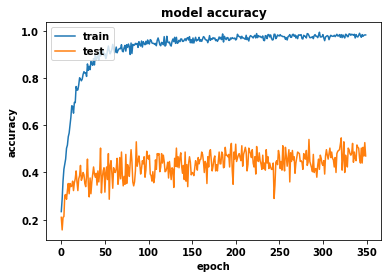

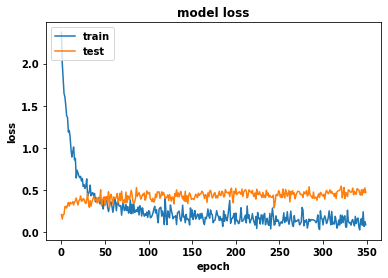

In [0]:
print(history.history.keys())
# summarize history for accuracy
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy', fontweight="bold")
plt.ylabel('accuracy', fontweight="bold")
plt.xlabel('epoch',fontweight="bold")
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_acc'])
plt.title('model loss', fontweight="bold")
plt.ylabel('loss', fontweight="bold")
plt.xlabel('epoch', fontweight="bold")
plt.legend(['train', 'test'], loc='upper left')
plt.show()

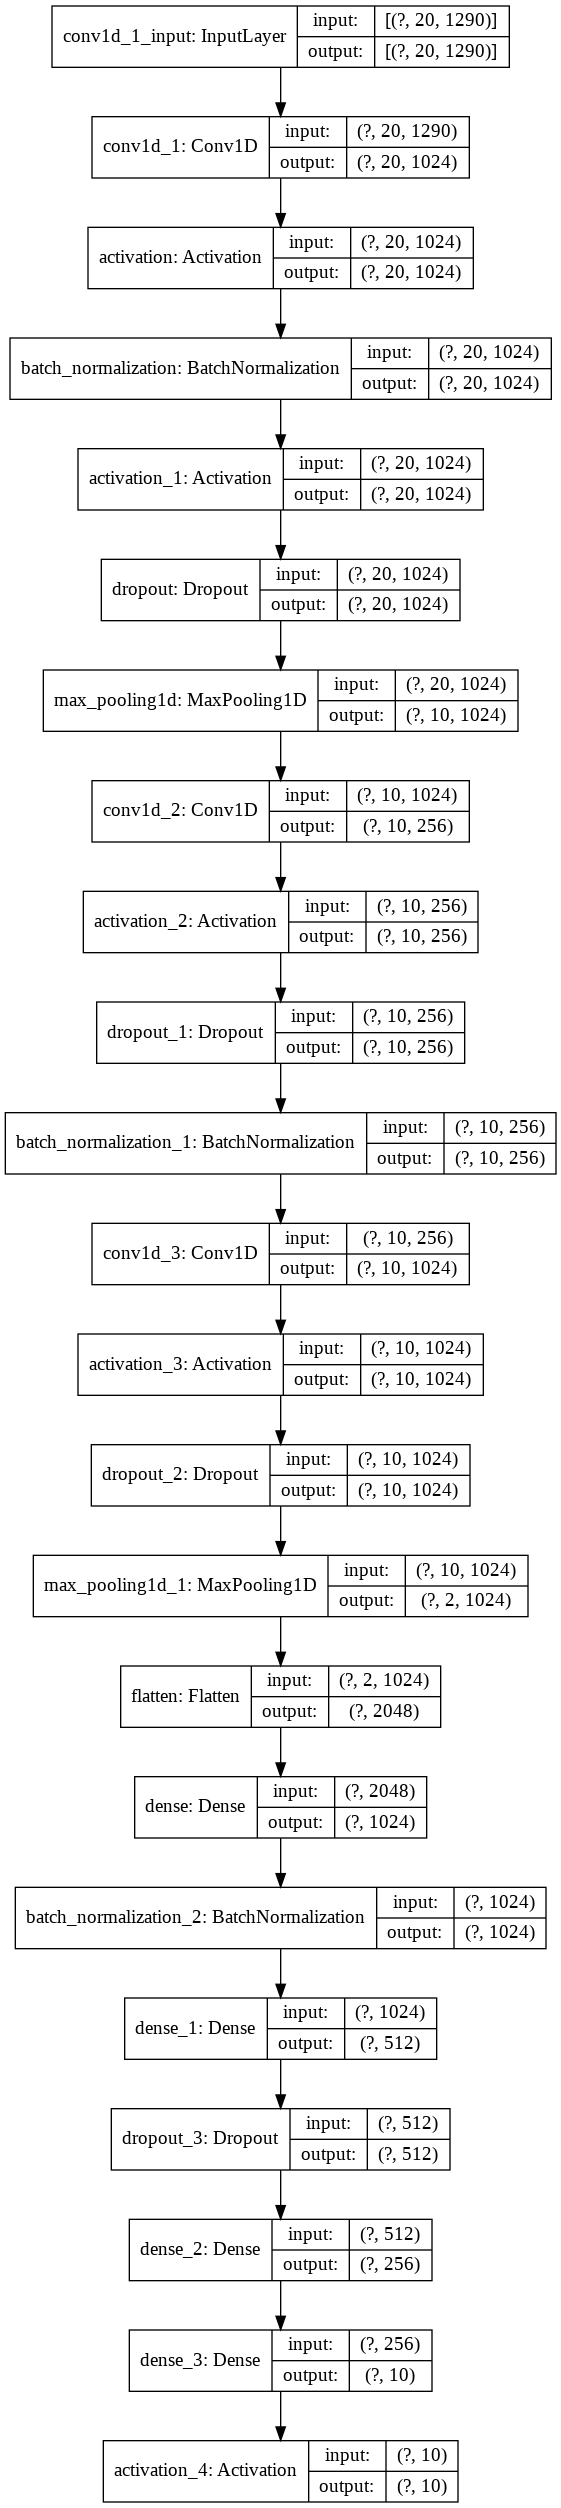

In [0]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
